In [1]:
from matplotlib import pyplot as plt

import os 
import glob
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
from tiler import Tiler

/opt/homebrew/anaconda3/envs/vesuvius-challenge-ink-detection-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

FRAGMENTS_PATH = '../data/raw/train'
TRAIN_FRAGMENTS = ['1', '2']
VAL_FRAGMENTS = ['3']

Z_START = 27
Z_DIM = 10
TILE_SIZE = 256

In [3]:
def tile_fragment(fragment):
    fragment_path = os.path.join(FRAGMENTS_PATH, fragment)
    slices_path = sorted(glob.glob(os.path.join(fragment_path, 'surface_volume/*.tif')))[Z_START:Z_START+Z_DIM]
    slices = [cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE) / 255.0 for slice_path in slices_path]
    slices = np.stack(slices, axis=0)

    slices_tiler = Tiler(data_shape=slices.shape,
                         tile_shape=(Z_DIM, TILE_SIZE, TILE_SIZE),
                         overlap=0.5, 
                         channel_dimension=0)

    new_shape, padding = slices_tiler.calculate_padding()
    slices_tiler.recalculate(data_shape=new_shape)
    slices_pad = np.pad(slices, padding)

    ink_path = os.path.join(FRAGMENTS_PATH, fragment, 'inklabels.png')
    ink = cv2.imread(ink_path, cv2.IMREAD_GRAYSCALE) / 255.0

    ink_tiler = Tiler(data_shape=ink.shape,
                            tile_shape=(TILE_SIZE, TILE_SIZE),
                            overlap=0.5)

    new_shape, padding = ink_tiler.calculate_padding()
    ink_tiler.recalculate(data_shape=new_shape)
    ink_pad = np.pad(ink, padding)

    slices_list = []
    ink_list = []
    tiles_zip = zip(slices_tiler(slices_pad), ink_tiler(ink_pad))

    for slices_tile, ink_tile in tiles_zip: 
        if ink_tile[1].max() > 0:
            # for the multi-context dataset we have to create a bigger padded
            # image to retrieve bigger image from the center of the current tile
            tile_bbox = slices_tiler.get_tile_bbox(slices_tile[0])
            slices_list.append(torch.from_numpy(slices_tile[1].astype('float16')))
            ink_list.append(torch.from_numpy(ink_tile[1].astype('float16')))
            
    slices = torch.stack(slices_list, dim=0).to(DEVICE)
    ink = torch.stack(ink_list, dim=0).to(DEVICE)
            
    return slices, ink

In [7]:
class CustomDataset(Dataset):
    def __init__(self, fragments):
        self.slices = torch.HalfTensor().to(DEVICE)
        self.ink = torch.HalfTensor().to(DEVICE)
        
        for fragment in fragments:
            slices, ink = tile_fragment(fragment)
            self.slices = torch.cat((self.slices, slices), dim=0)
            self.ink = torch.cat((self.ink, ink), dim=0)
        
    def __len__(self):
        return len(self.slices)
    
    def __getitem__(self, idx):
        slices = torch.unsqueeze(self.slices[idx], dim=0)
        ink = torch.unsqueeze(torch.unsqueeze(self.ink[idx], dim=0), dim=0)
        
        return slices, ink

In [8]:
train_dataset = CustomDataset(TRAIN_FRAGMENTS)

In [12]:
slices, ink = train_dataset[876]

In [13]:
slices.shape, ink.shape

(torch.Size([1, 10, 256, 256]), torch.Size([1, 1, 256, 256]))

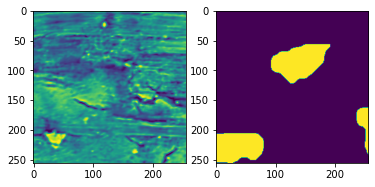

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(slices[0, 0, :, :].cpu())
ax2.imshow(ink[0, 0, :, :].cpu())